In [1]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt
import ta

This code involves a comprehensive workflow for loading financial data, performing various time series analyses, fitting multiple arithmetic, machine learning and deep learning models, and visualizing the results.

This block defines the directory structure and reads CSV files from the subdirectories into dataframes, storing them in a dictionary.

In [2]:
# Define the main directory and subdirectories
main_dir = 'data/FinancialData'
sub_dirs = ['cryptocurrencies', 'currencies', 'stocks']

# Initialize a dictionary to hold dataframes
data_dict = {}

# Loop over each subdirectory
for sub_dir in sub_dirs:
    # Construct the full path to the subdirectory
    full_path = os.path.join(main_dir, sub_dir)
    
    # Initialize a list to hold dataframes for the current subdirectory
    df_list = []
    
    # Check if the directory exists
    if os.path.isdir(full_path):
        # Loop over each file in the subdirectory
        for file_name in os.listdir(full_path):
            # Construct the full path to the file
            file_path = os.path.join(full_path, file_name)
            
            # Check if it's a file (not a directory)
            if os.path.isfile(file_path):
                # Extract the file name without extension
                file_base_name = os.path.splitext(file_name)[0]
                
                # Read the file into a dataframe
                df = pd.read_csv(file_path)  # Adjust according to the file type
                
                # Add a column with the file name
                df['source_file'] = file_base_name
                
                # Append the dataframe to the list
                df_list.append(df)
    
    # Concatenate all dataframes for the current subdirectory into a single dataframe
    if df_list:
        data_dict[sub_dir] = pd.concat(df_list, ignore_index=True)
    else:
        data_dict[sub_dir] = pd.DataFrame()  # Create an empty dataframe if no files were found

# The dataframes are now stored in variables named after the folders
cryptocurrencies_df = data_dict['cryptocurrencies']
currencies_df = data_dict['currencies']
stocks_df = data_dict['stocks']

print(cryptocurrencies_df.head())
print(currencies_df.head())
print(stocks_df.head())

       Open      High       Low     Close    Volume  Year   YTD Gain  \
0  0.025160  0.035060  0.025006  0.032053  18716200  2017   0.000000   
1  0.032219  0.033348  0.026451  0.027119   6766780  2017 -15.393260   
2  0.026891  0.029659  0.025684  0.027437   5532220  2017 -14.401153   
3  0.027480  0.027952  0.022591  0.023977   7280250  2017 -25.195772   
4  0.024364  0.026300  0.023495  0.025808   4419440  2017 -19.483362   

  source_file  
0     ADA-USD  
1     ADA-USD  
2     ADA-USD  
3     ADA-USD  
4     ADA-USD  
     Open    High     Low   Close  Volume  Year  YTD Gain source_file
0  1.3109  1.3146  1.3004  1.3036       0  2006  0.000000         AUD
1  1.3040  1.3200  1.2943  1.3168       0  2006  1.012584         AUD
2  1.3168  1.3180  1.3028  1.3089       0  2006  0.406570         AUD
3  1.3091  1.3280  1.3075  1.3207       0  2006  1.311759         AUD
4  1.3212  1.3385  1.3212  1.3273       0  2006  1.818042         AUD
         Date      Open      High       Low     Clo

This section selects data for a specific stock (AAPL), converts the date column to datetime, sets it as the index, ensures daily frequency, and interpolates missing values.

In [3]:
df = stocks_df[stocks_df['source_file'] == 'AAPL'].copy()  # Create a copy to avoid SettingWithCopyWarning
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])  # Use .loc to modify the Date column
df.set_index('Date', inplace=True)
df = df.asfreq('D')  # Ensure the data is daily frequency
df['Close'].interpolate(inplace=True)  # Fill missing values

Fits an ARIMA model to the closing prices and forecasts future values, which are then plotted.

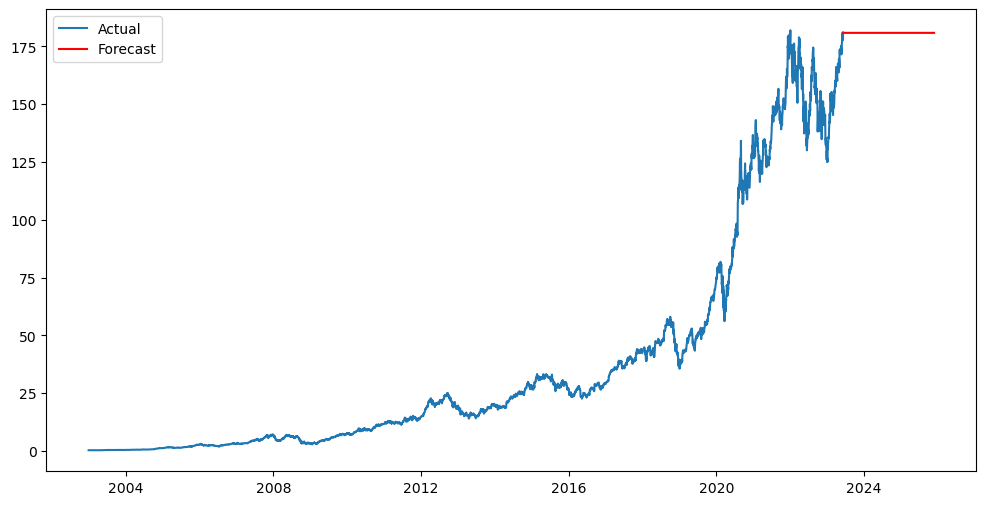

In [4]:
# Fit ARIMA model
model = ARIMA(df['Close'], order=(5, 1, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=900)
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

Computes daily returns, fits a GARCH model, and forecasts volatility, which is plotted alongside actual prices.

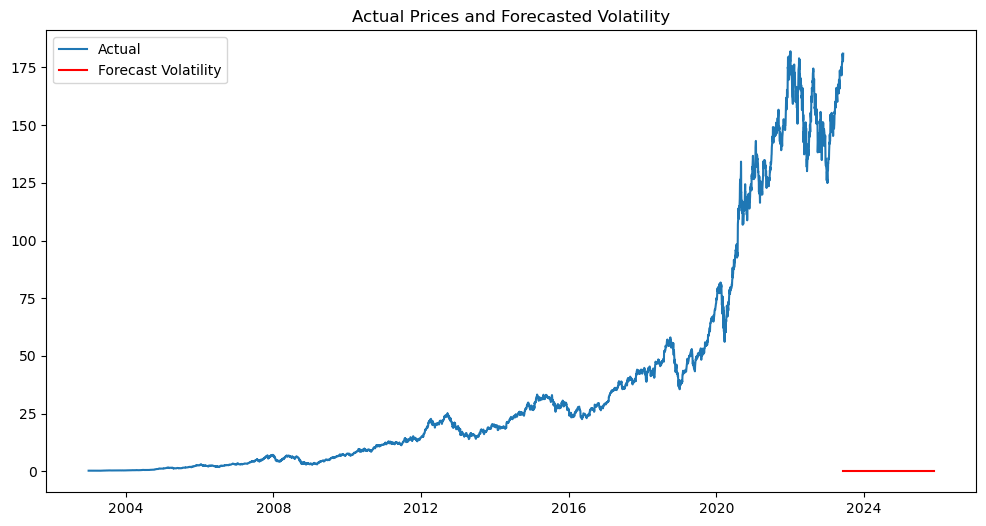

In [5]:
returns = df['Close'].pct_change().dropna()

# Rescale the returns
rescaled_returns = returns * 100

# Fit a GARCH(1,1) model to the rescaled returns
model = arch_model(rescaled_returns, vol='Garch', p=1, q=1)
model_fit = model.fit(disp='off')

# Forecast the next 900 days
forecast = model_fit.forecast(horizon=900)

# Extract forecasted volatility (variance) and rescale back to original scale
forecast_variance = forecast.variance.iloc[-1] / (100 ** 2)

# Plot actual data and forecasted volatility
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Actual')
plt.plot(pd.date_range(df.index[-1], periods=900, freq='D'), forecast_variance, label='Forecast Volatility', color='red')
plt.legend()
plt.title('Actual Prices and Forecasted Volatility')
plt.show()

Prepares data for the Random Forest model, fits the model, makes predictions, and plots the results.

MSE: 5737.2902391689095


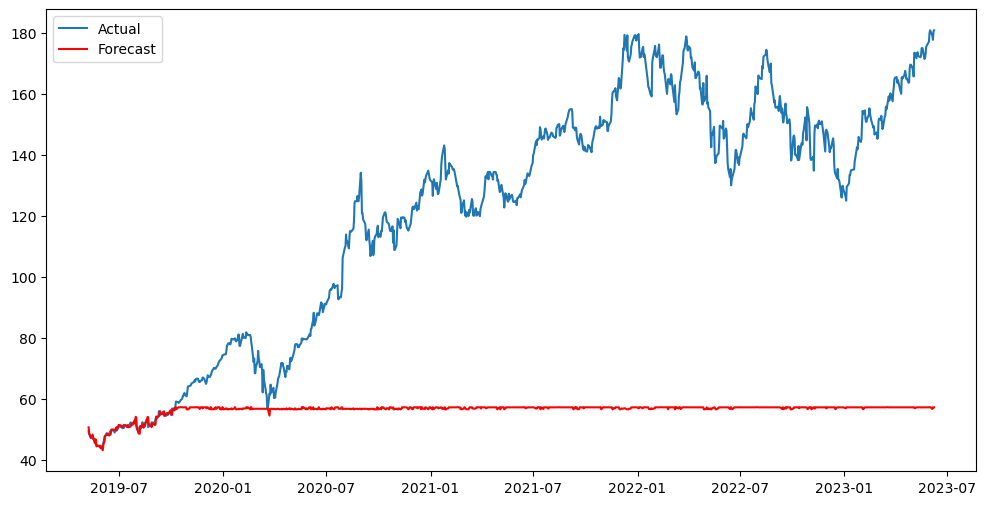

In [6]:
# Prepare features and target
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit Random Forest model
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, predictions)}')

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions, label='Forecast', color='red')
plt.legend()
plt.show()

Adds new features to the dataframe, scales them using RobustScaler, and splits the data for training and testing.
Performs hyperparameter tuning for the XGBoost model, trains it, and evaluates its performance.
Plots the actual vs. forecasted prices, residuals, and feature importance for the XGBoost model.

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}
MSE: 5889.993923555115
MAE: 66.29501491184925
RMSE: 76.746295829539


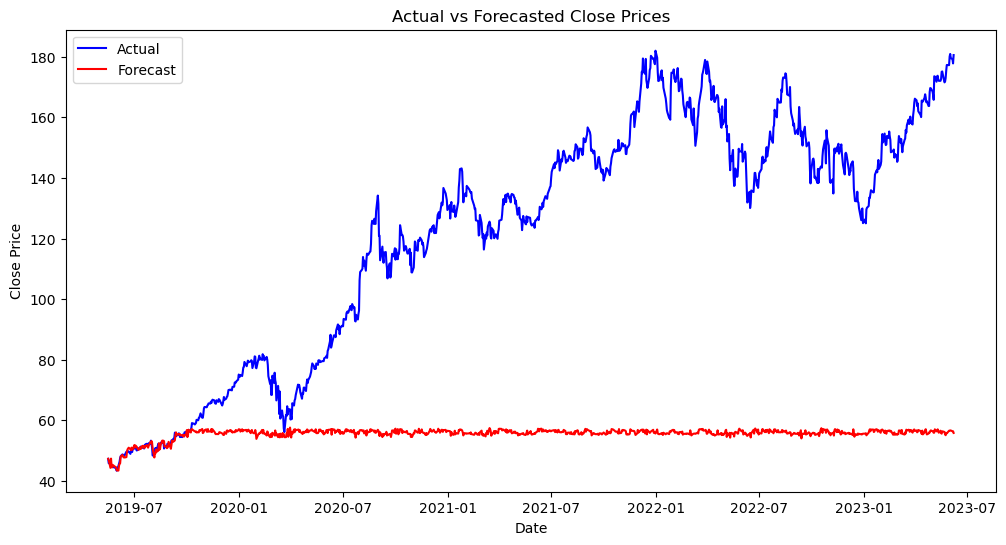

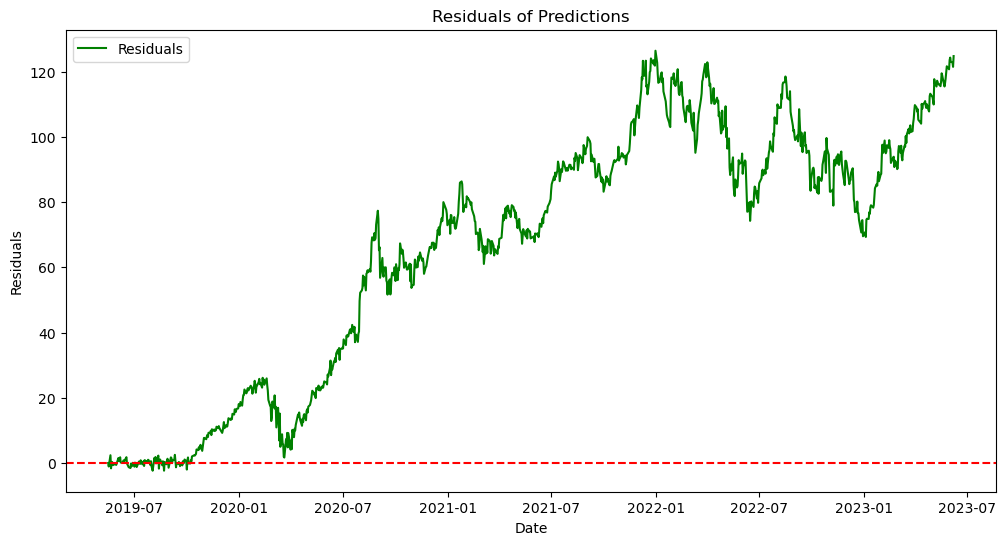

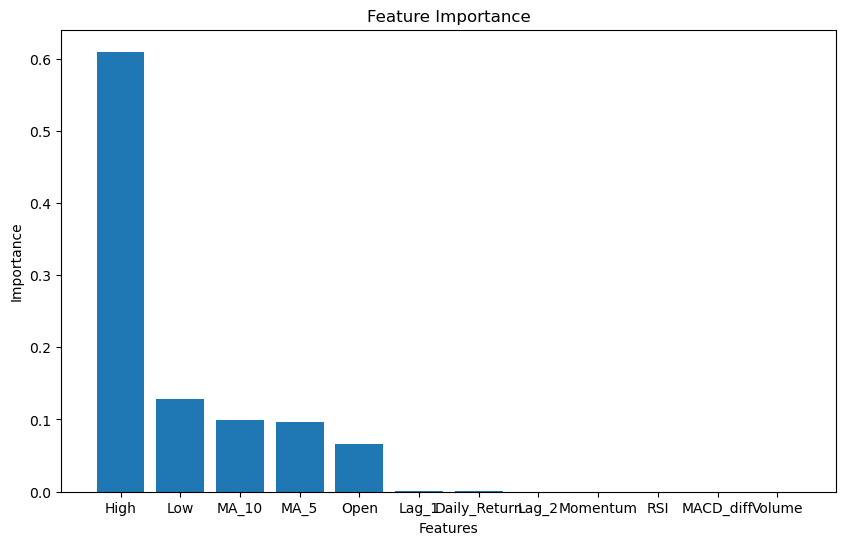

In [7]:
df['Target'] = df['Close'].shift(-1)
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['Momentum'] = df['Close'] - df['Close'].shift(5)
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)
df['Daily_Return'] = df['Close'].pct_change()

# Additional technical indicators
df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
df['MACD_diff'] = ta.trend.MACD(df['Close']).macd_diff()

# Ensure all new features are properly handled
df.dropna(inplace=True)

X = df[['Open', 'High', 'Low', 'Volume', 'MA_5', 'MA_10', 'Momentum', 'Lag_1', 'Lag_2', 'Daily_Return', 'RSI', 'MACD_diff']]
y = df['Target']

# Scaling the data using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame to retain feature names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, shuffle=False)

# Hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100),
                           param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Predict
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Plotting predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predictions, label='Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Forecasted Close Prices')
plt.show()

# Plotting residuals
residuals = y_test - predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, residuals, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Feature importance
importances = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

Scales the data, prepares it for LSTM input, splits it into training and test sets, builds and trains the LSTM model, and plots the actual vs. predicted prices.

Epoch 1/10
4040/4040 - 61s - 15ms/step - loss: 7.9809e-05
Epoch 2/10
4040/4040 - 81s - 20ms/step - loss: 3.4175e-05
Epoch 3/10
4040/4040 - 83s - 20ms/step - loss: 1.9773e-05
Epoch 4/10
4040/4040 - 82s - 20ms/step - loss: 2.0430e-05
Epoch 5/10
4040/4040 - 58s - 14ms/step - loss: 1.6377e-05
Epoch 6/10
4040/4040 - 59s - 15ms/step - loss: 1.3776e-05
Epoch 7/10
4040/4040 - 58s - 14ms/step - loss: 1.3900e-05
Epoch 8/10
4040/4040 - 58s - 14ms/step - loss: 1.2227e-05
Epoch 9/10
4040/4040 - 81s - 20ms/step - loss: 1.4151e-05
Epoch 10/10
4040/4040 - 62s - 15ms/step - loss: 1.1312e-05
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


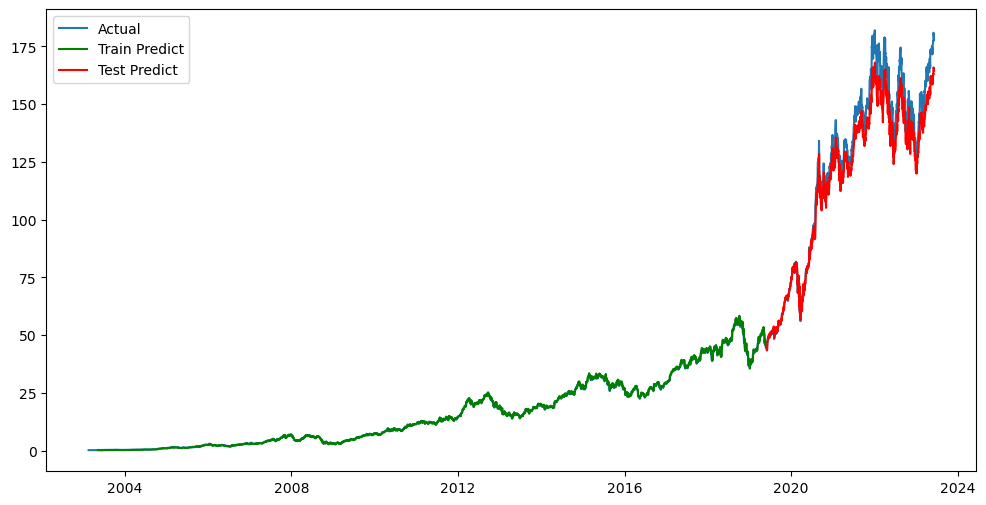

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# Prepare the data for LSTM
look_back = 60
X, y = [], []
for i in range(len(scaled_data) - look_back - 1):
    X.append(scaled_data[i:(i + look_back), 0])
    y.append(scaled_data[i + look_back, 0])
X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(look_back, 1)))  # Define input shape using Input layer
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and the true values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Actual')
plt.plot(df.index[look_back:train_size + look_back], train_predict, label='Train Predict', color='green')

# Adjust the indices for the test predictions
test_start_index = train_size + look_back
test_end_index = test_start_index + len(test_predict)
plt.plot(df.index[test_start_index:test_end_index], test_predict, label='Test Predict', color='red')

plt.legend()
plt.show()

In conclusion, it is evident that the provided data's erratic and complex structure poses significant challenges, even for a well-tuned and engineered machine learning model. Only the deep learning LSTM model achieved nearly precise predictions.

The aim of this project was to study and showcase a particularly difficult dataset, exploring different levels of model complexity and comparing their predictions step by step.